# Assignment 3

**Python module imports**

In [ ]:
from collections import Counter
from itertools import chain
from os import makedirs
import os.path

from matplotlib.colors import TABLEAU_COLORS
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import requests
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

## Task 1

#### Part (a)

**Dataset download**

In [ ]:
makedirs(data_dir := "data", exist_ok=True)

for dataset in (datasets := ("train", "test")):
    with open(os.path.join(data_dir, f"{dataset}.csv"), "wb") as file:
        file.write(requests.get(f"https://raw.githubusercontent.com/76e917fe/df48d1eb/main/{dataset}.csv").content)

**Dataset import and vectorisation**

In [ ]:
train_data_raw, train_classes_raw, test_data_raw, test_classes_raw = chain.from_iterable(
    (read_csv(os.path.join(data_dir, f"{dataset}.csv"))[column].tolist() for column in ("Text", "Category"))
    for dataset in datasets
)

train_data, test_data = (CountVectorizer(token_pattern=r"(?u)\b\w+\b").fit(train_data_raw).transform(dataset_data) for dataset_data in (train_data_raw, test_data_raw))
train_classes, test_classes = ([cls.replace("tech", "technology").title() for cls in dataset_classes] for dataset_classes in (train_classes_raw, test_classes_raw))

classes = sorted(set(train_classes))

word_counts = dict(Counter(" ".join(train_data_raw).split()))
word_counts_by_class = {
    cls: dict(Counter(" ".join(text for text, text_class in zip(train_data_raw, train_classes) if text_class == cls).split()))
    for cls in classes
}
vocabulary = sorted(word_counts.keys())

**Data metrics**

In [ ]:
print(f"Number of articles: {train_data.shape[0]}")
print(f"Number of features: {train_data.shape[1]}")

Number of articles: 428
Number of features: 13545


**Vectorised article samples**

In [ ]:
for i in range(5):
    print(f"Article {i + 1}: {train_data[i].toarray()[0].tolist()}")

Article 1: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

#### Part (b)

**Top 50 words by frequency**

In [ ]:
top_words, top_counts = zip(*sorted(word_counts.items(), key=lambda item: item[1])[-1 * (top_count := 50):])

top_words_by_class, top_counts_by_class = ({
    cls: list(zip(*sorted(class_word_counts.items(), key=lambda item: item[1])[-1 * top_count:]))[i]
    for cls, class_word_counts in word_counts_by_class.items()
} for i in (0, 1))

**Word frequency and class distribution plots**

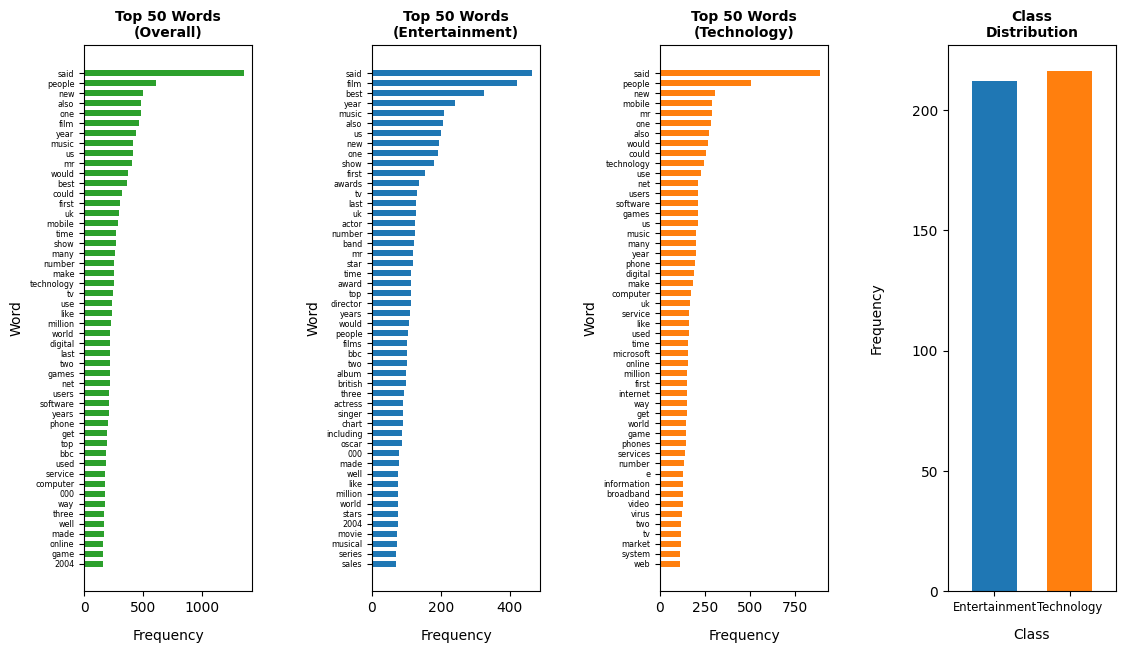

In [ ]:
# Setting up the plots

figure, axes = plt.subplots(1, len(classes) + 2, figsize=(12, 7))
figure.tight_layout(w_pad=6)
figure.subplots_adjust(left=0.1, bottom=0.1, top=0.88, right=0.96)

# Plot overall word frequency distribution

axes[0].barh(range(top_count), top_counts, height=(bar_height := 0.6), color="tab:green")

axes[0].set_yticks(range(top_count), top_words, fontsize="xx-small")
axes[0].set_title("Top 50 Words\n(Overall)", fontsize="medium", fontweight="bold")
axes[0].set_xlabel("Frequency", labelpad=10)
axes[0].set_ylabel("Word")

# Plot word frequency distribution by class

for i, cls, color in zip(range(len(classes)), classes, TABLEAU_COLORS):
    axes[i+1].barh(range(top_count), top_counts_by_class[cls], height=bar_height, color=color)

    axes[i+1].set_yticks(range(top_count), top_words_by_class[cls], fontsize="xx-small")
    axes[i+1].set_title(f"Top 50 Words\n({cls})", fontsize="medium", fontweight="bold")
    axes[i+1].set_xlabel("Frequency", labelpad=10)
    axes[i+1].set_ylabel("Word")

# Plot class distribution

axes[-1].bar(classes, Counter(sorted(train_classes)).values(), color=TABLEAU_COLORS, width=0.6)

axes[-1].margins(x=0.2)
axes[-1].set_xticks(axes[-1].get_xticks(), axes[-1].get_xticklabels(), fontsize="small")
axes[-1].set_title("Class\nDistribution", fontsize="medium", fontweight="bold")
axes[-1].set_xlabel("Class", labelpad=10)
axes[-1].set_ylabel("Frequency", labelpad=20)

# Display the plots

plt.show()

## Task 2

In [ ]:
models = {}

### Part (a) - NB

**Model construction and fit**

In [ ]:
# Naive Bayes Classifier
models["nb"] = (
    ("Multinomial Naïve Bayes Model", MultinomialNB()),
)

for _, model in models["nb"]:
    model.fit(train_data, train_classes)

**Top-20 word lists**

In [ ]:
feature_names = vocabulary
class_A_probs = np.exp(models["nb"][0][1].feature_log_prob_[0])
class_B_probs = np.exp(models["nb"][0][1].feature_log_prob_[1])

# Top-20 Most Identifable words
word_dif = class_A_probs - class_B_probs
A_top_20_indicies = word_dif.argsort()[-20:][::-1]
B_top_20_indicies = word_dif.argsort()[:20]

A_top_20_words = [feature_names[i] for i in A_top_20_indicies]
B_top_20_words = [feature_names[i] for i in B_top_20_indicies]

print("Top-20 most identifiable words in Entertainment: \n")
for i in range(len(A_top_20_words)):
    print("{}. {}".format(i+1, A_top_20_words[i]))

print()

print("Top-20 most identifiable words Technology: \n")
for i in range(len(B_top_20_words)):
    print("{}. {}".format(i+1, B_top_20_words[i]))

A_word_ratios = class_A_probs / class_B_probs
A_top_20_indices_max = A_word_ratios.argsort()[-20:][::-1]
A_top_20_words_max = [feature_names[i] for i in A_top_20_indices_max]

B_word_ratios = class_B_probs / class_A_probs
B_top_20_indices_max = B_word_ratios.argsort()[-20:][::-1]
B_top_20_words_max = [feature_names[i] for i in B_top_20_indices_max]

print("\nTop-20 words maximizing the quantity for Entertainment:\n")
for i in range(len(A_top_20_words_max)):
    print(f"{i + 1}. {A_top_20_words_max[i]}")

print("\nTop-20 words maximizing the quantity for Technology:\n")
for i in range(len(B_top_20_words_max)):
    print(f"{i + 1}. {B_top_20_words_max[i]}")

Top-20 most identifiable words in Entertainment: 

1. film
2. best
3. awards
4. actor
5. band
6. show
7. star
8. award
9. album
10. year
11. actress
12. singer
13. chart
14. oscar
15. british
16. director
17. films
18. stars
19. musical
20. theatre

Top-20 most identifiable words Technology: 

1. people
2. mobile
3. said
4. technology
5. users
6. software
7. net
8. use
9. games
10. phone
11. computer
12. could
13. microsoft
14. digital
15. phones
16. online
17. internet
18. service
19. services
20. broadband

Top-20 words maximizing the quantity for Entertainment:

1. actress
2. singer
3. oscar
4. stars
5. aviator
6. band
7. nominated
8. festival
9. rock
10. album
11. nominations
12. charles
13. chart
14. foxx
15. oscars
16. starring
17. singles
18. jamie
19. swank
20. comedy

Top-20 words maximizing the quantity for Technology:

1. users
2. software
3. microsoft
4. mobile
5. broadband
6. virus
7. firms
8. pc
9. spam
10. phones
11. gadget
12. net
13. consumer
14. mobiles
15. windows
16

**Analysis**

The first list (i) finds the difference in the probabilities between the two classes technology and entertainment. This means that the words on this list are more likely to occur significantly more frequently in one class than the other.

The second list (ii) contains the words that have the highest ratio of probabilities between the two classes. Words in this class are more likely to occur within a specific class compared to the other, emphasising their significance within a specific class.

The first list (i) lacks this specificity and contains words that can be applied to both classes.

Because of this, the second list that maximises
$ \frac{P(X_w = 1 | Y = y)}{P(X_w = 1 | Y ≠ y)} $
is the better descriptor of of the two classes as it provides more specific insights into the specific classes.

### Part (b) - kNN

In [ ]:
#K-nearest Neighbours Classifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import numpy as np

test_data_raw_, test_classes_raw_ = (read_csv(os.path.join(data_dir, "test.csv"))[column].tolist() for column in ("Text", "Category"))

test_data_ = CountVectorizer(token_pattern=r"(?u)\b\w+\b").fit_transform(test_data_raw_)
test_classes_ = [cls.replace("tech", "technology").title() for cls in test_classes_raw_]

text_knn = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('knn', KNeighborsClassifier(n_neighbors=10, p=2, metric='minkowski')), #p=2 is euclidean distance, n_neighbours = k
     ])

text_knn.fit(train_data_raw, train_classes)
predicted = text_knn.predict(test_data_raw)

knn_confusion_matrix = metrics.confusion_matrix(test_classes_, predicted)
print(metrics.classification_report(test_classes_, predicted,target_names=classes))

               precision    recall  f1-score   support

Entertainment       0.98      0.98      0.98        61
   Technology       0.98      0.98      0.98        45

     accuracy                           0.98       106
    macro avg       0.98      0.98      0.98       106
 weighted avg       0.98      0.98      0.98       106



**2D dimensionality reduction**

In [ ]:
train_data_2D = TruncatedSVD(random_state=0).fit_transform(train_data)

**Model construction and fit**

In [ ]:
models["knn"] = (
    (f"K-Nearest Neighbour Model (k = {(k := 10)})", KNeighborsClassifier(n_neighbors=k)),
)

for _, model in models["knn"]:
    model.fit(train_data_2D, train_classes)

**Surface plot**

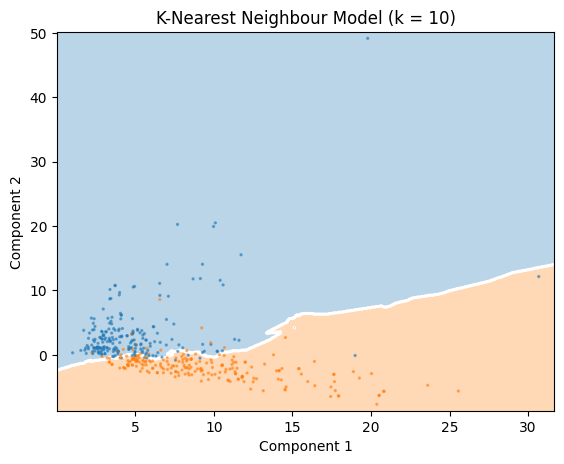

In [ ]:
# Mapping training classes to colors
colors = [list(TABLEAU_COLORS.keys())[classes.index(cls) % len(TABLEAU_COLORS)] for cls in train_classes]

for name, model, axes in zip(*zip(*models["knn"]), plt.subplots(len(models["knn"]), 1, figsize=(6, 5 * len(models["knn"])), squeeze=False)[1].ravel()):
    # Plotting 2D training instance projections
    axes.scatter(*train_data_2D.T, alpha=0.5, c=colors, s=2, zorder=3)

    # Plotting the decision boundary and classification regions
    display = DecisionBoundaryDisplay.from_estimator(model, train_data_2D, response_method="predict", ax=axes, grid_resolution=600, alpha=0.3, colors=list(TABLEAU_COLORS.keys()), levels=1)
    display.plot(plot_method="contour", ax=axes, colors="white", levels=1, linewidths=2)

    axes.set_title(name)
    axes.set_xlabel("Component 1")
    axes.set_ylabel("Component 2")

plt.tight_layout(pad=2)
plt.show()

**Hyperparameter interpretation**

The effect of the hyperparameter K, in K-Nearest neighbours has a great impact on the performance of the algorithm. Setting K too high will underfit the data by making everything probable, while setting K too low will overfit the data and can cause a small amount of data to have a significant impact on the classifier. In turn this will also affect the smoothless of the boundary.

On our dataset with K=10, we have an fairly clean boundary in the dense areas with a small amount of mis-classification. Decreasing the value of K could place these data point on the correct side, however this would make the boundary significatly more erratic, leading to sharp edges and possibly overfitting. There is a large jagged edge at (C1=14,C2=2), K could be increased to smooth this out, however this would likely have a major impact on the boundary in the dense areas.

The distance metric used is Euclidean distance, the Euclidean distance is omnidirection and generally better for datasets which don't have a significant number of features. Due to Euclidean distance being omnidirectional is also can produce smooth boundaries. An alternative is manhatten distance, which calculates distance using horizontal and vertical axis, producing straight and blocky boundaries.

### Part (c) - SVM

**Model construction and fit**

In [ ]:
models["svm"] = (
    (f"Soft-Margin Linear SVM (C = {(C := 0.01)})", SVC(kernel="linear", C=C)),
    (f"Hard-Margin RBF Kernel SVM (σ = {1 / np.sqrt(2 * (gamma := 1.18)):.2f})", SVC(kernel="rbf", C=1e12, gamma=gamma))
)

for _, model in models["svm"]:
    model.fit(train_data_2D, train_classes)

**Surface plots**

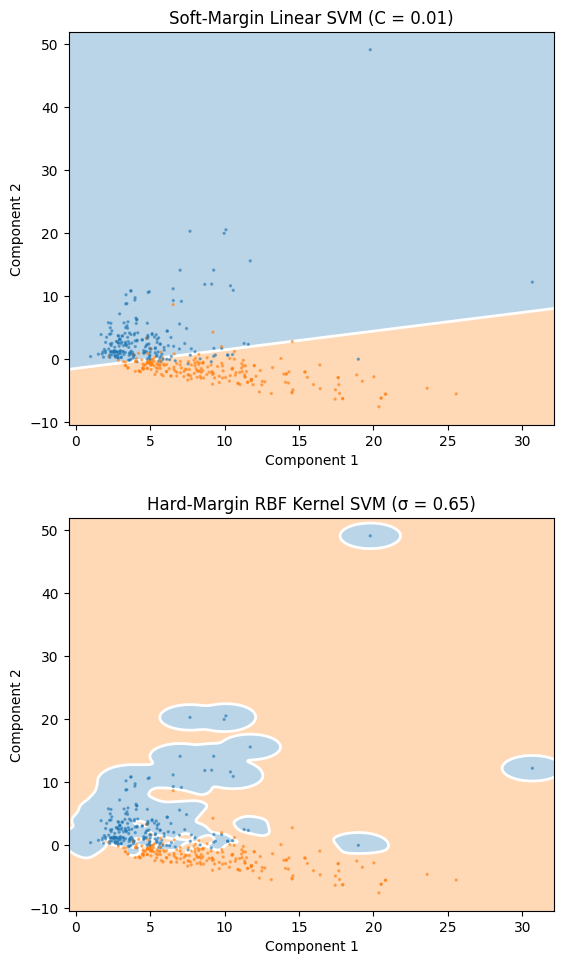

In [ ]:
for name, model, axes in zip(*zip(*models["svm"]), plt.subplots(len(models["svm"]), 1, figsize=(6, 5 * len(models["svm"])), squeeze=False)[1].ravel()):
    # Plotting 2D training instance projections
    axes.scatter(*train_data_2D.T, alpha=0.5, c=colors, s=2, zorder=3)

    x, y = np.meshgrid(*(np.linspace(*getattr(axes, f"get_{a}lim")(), 500) for a in ("x", "y")))
    z = model.decision_function(np.stack((x.ravel(), y.ravel()), axis=-1)).reshape(x.shape)

    # Plotting the decision boundary and classification regions
    axes.contourf(x, y, z, alpha=0.3, colors=list(TABLEAU_COLORS.keys()), levels=0)
    axes.contour(x, y, z, colors="white", levels=0, linewidths=2)

    axes.set_title(name)
    axes.set_xlabel("Component 1")
    axes.set_ylabel("Component 2")

plt.tight_layout(pad=2)
plt.show()

**Hyperparameter interpretation**

In the context of a soft-margin linear SVM, the value of $ C $ determines how "soft" the margin is allowed to be. That is, how the extent to which fit is allowed to misclassify the training data. A low value of $ C $ allows for more misclassifications to occur, while a higher value penalises misclassifications more, attempting to create a "harder" linear margin between the instance points in each class. Though a lower $ C $ may result in a lower training error, the resultant model may generalise better to new instances, so can be adjusted to prevent overfitting.

In the context of a hard-margin RBF kernel SVM, the value of $ \sigma $ determines the extent to which individual instances can affect the shape of the decision boundary. A low value of $ \sigma $ results in a tight decision boundary around training instances, while a larger value results in a more flexible model, with larger regions around instances that would classify new instances as being in the same class. The hard margin means that the all training instances must be classified correctly, resulting in a training error of 100%, and this does not change regardless of the value of $ \sigma $. However, $ \sigma $ can be adjusted to prevent overfitting, as larger values usually make the decision boundary less complex and decrease the number of disjoint classification regions about training instances. This results in a model that may generalise better to new instances, due to the decreased sensitivity of the model to training instance positions.

### Part (d) - NN

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

epochs = 100
X_train, X_test, y_train, y_test = train_test_split(train_data, train_classes, test_size=0.2,random_state=42)
X_train_batches = np.array_split(X_train.toarray(), epochs)
y_train_batches = np.array_split(y_train, epochs)
classes = np.unique(y_train)

In [ ]:
models["nn"] = (
    (f"Hidden Layers: {(n := 5)}", MLPClassifier(random_state=0,hidden_layer_sizes=(n,),learning_rate_init=0.01, max_iter=epochs)),
    (f"Hidden Layers: {(n := 20)}", MLPClassifier(random_state=0,hidden_layer_sizes=(n,),learning_rate_init=0.01, max_iter=epochs)),
    (f"Hidden Layers: {(n := 40)}", MLPClassifier(random_state=0,hidden_layer_sizes=(n,),learning_rate_init=0.01, max_iter=epochs)),
)

loss_list = {}
for name, model in models["nn"]:
  for i in range(epochs):
    model.partial_fit(X_train_batches[i], y_train_batches[i],classes=classes)
    if name in loss_list:
      loss_list[name].append(model.loss_)
    else:
      loss_list[name] = [model.loss_]

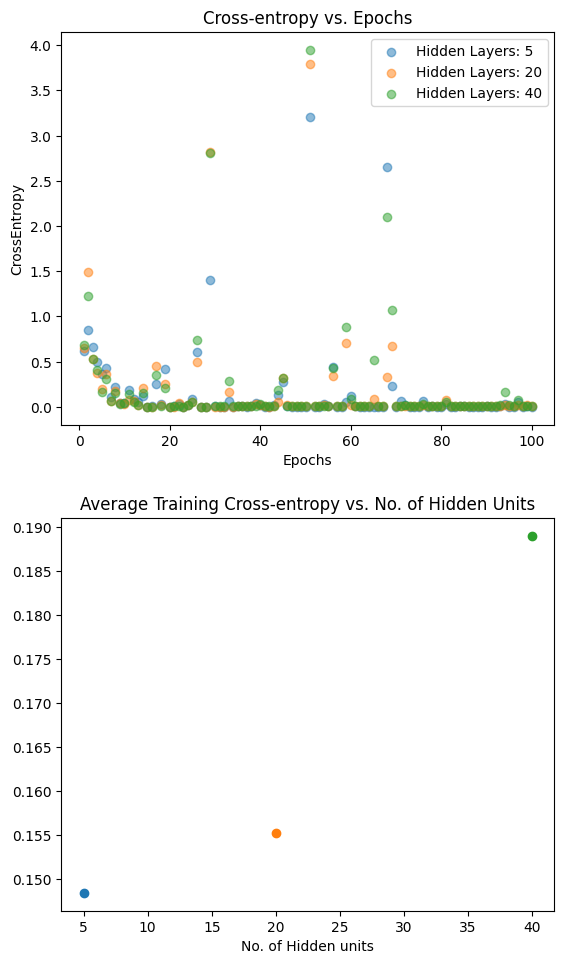

In [ ]:
### Plotting Cross-entropy loss over epochs
fig, axes = plt.subplots(2, 1, figsize=(6, 10))

for name, model in loss_list.items():
    axes[0].scatter([i+1 for i in range(epochs)],model,label=name, alpha=0.5)

axes[0].set_title("Cross-entropy vs. Epochs")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('CrossEntropy')
axes[0].legend()

### Plotting Average Cross-entropy loss over no. of hidden units

for (name, model),hidden_layer_size in zip(loss_list.items(),[5,20,40]):
    axes[1].scatter(hidden_layer_size,np.average(model),label=name)

axes[1].set_title("Average Training Cross-entropy vs. No. of Hidden Units")
axes[1].set_xlabel('Epochs')
axes[1].set_xlabel('No. of Hidden units')

plt.tight_layout(pad=2)
plt.show()

#### Summary
The effect of numbers of hidden units on cross-entropy loss is that as the No. of hidden units increases, so does the cross-entropy loss.
According to the 2nd graph, there is an exponential relationship between the cross entropy loss and the no. of hidden units.

On the 1st graph, we can see that baring spikes, the cross-entropy loss curves are quite similar, decreasing until roughly epoch 10, where the loss basically flat-lines.

The spikes in the 1st graph explains why the higher the hidden unit count, the higher the average cross-entropy, as although each model spikes at around the same epoch, the higher hidden unit count perhaps captures more incorrect information at that epoch and hence has a higher spike in cross-entropy loss.

## Task 3

#### Part (a)

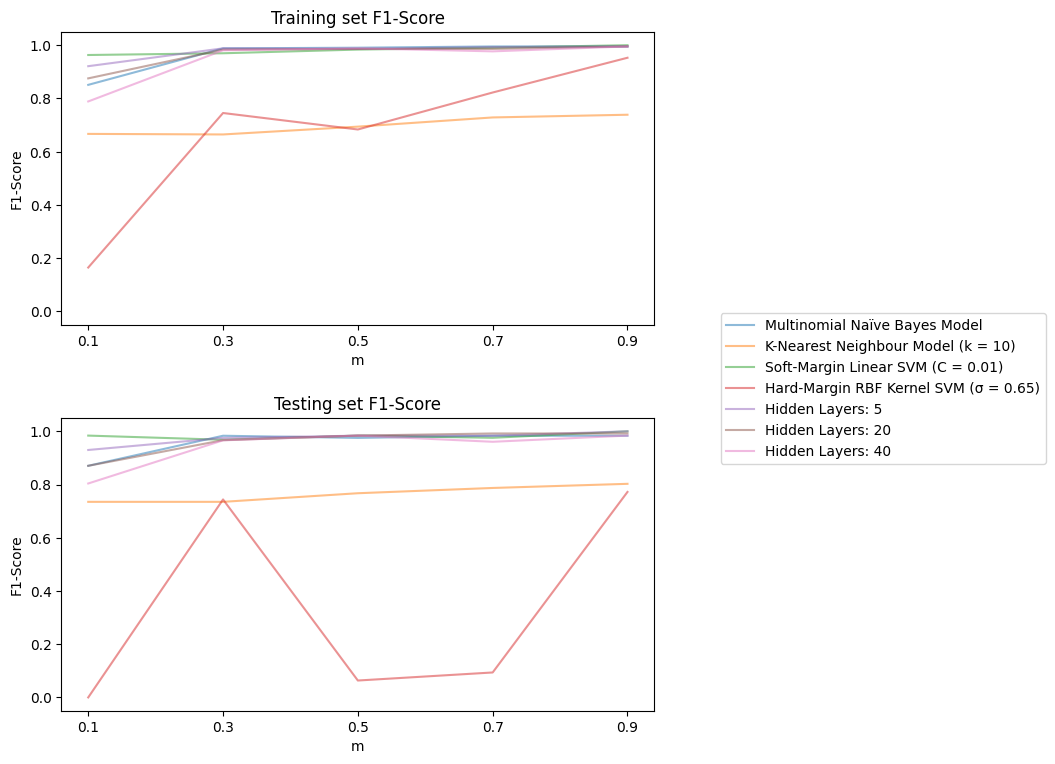

In [ ]:
ms = (0.1, 0.3, 0.5, 0.7, 0.9)

for dataset, axes, dataset_data, dataset_classes in zip(datasets, plt.subplots(2, 1, figsize=(7, 8))[1], (train_data, test_data), (train_classes, test_classes)):
    for name, model in chain.from_iterable(models.values()):
        axes.plot(ms, [
            f1_score(dataset_classes, model.fit(train_data[:split_index], train_classes[:split_index]).predict(dataset_data), pos_label=classes[0])
            for split_index in (round(m * train_data.shape[0]) for m in ms)
        ], alpha=0.5)

    axes.set_xticks(ms)
    axes.set_xlabel("m")
    axes.set_ylim(-0.05, 1.05)
    axes.set_ylabel("F1-Score")
    axes.set_title(f"{dataset.title()}ing set F1-Score")

plt.tight_layout(pad=2)
plt.legend(list(zip(*chain.from_iterable(models.values())))[0], loc="center left", bbox_to_anchor=(1.1, 1.1))
plt.show()

The training and test F1-Scores for the Naive Bayes, Soft-Margin SVM and Neutral Network models all have similar plots when comparing their training and test F1-Scores. There is a significant difference in both plots between m = 0.1, and m=0.3, as this is when they converge, with little changes to the F1-Score as more data is trained on. These models have the highest F1-Scores

The K-Nearest Neighbours model follows a similar trend for F1-Scores in both plots, with a slight linear increase as m increases. The F-1 Score is about 10% higher on the test set over the training set.

The size of the data trained on has a significant impact on the F1-Score on the Hard-Margin SVM. On the training set, the F1-Score of the Hard-Margin SVM saw a huge increase from m=0.1 to m=0.5, after which the F1-Score had a slight drop, followed by a linear increase at m increased. On the test set the F1-Score of the Hard-Margin SVM has the lowest F-1 Score at 0, shooting up to F1-Score = 0.75 at m=0.3 before dropping down to F1-Score = 0.1 at m=0.5. This is followed by a slight increase at m=0.7 before shooting up at F1-Score = 0.75 at m=0.9, similar to that at m=0.3.

#### Part (b)

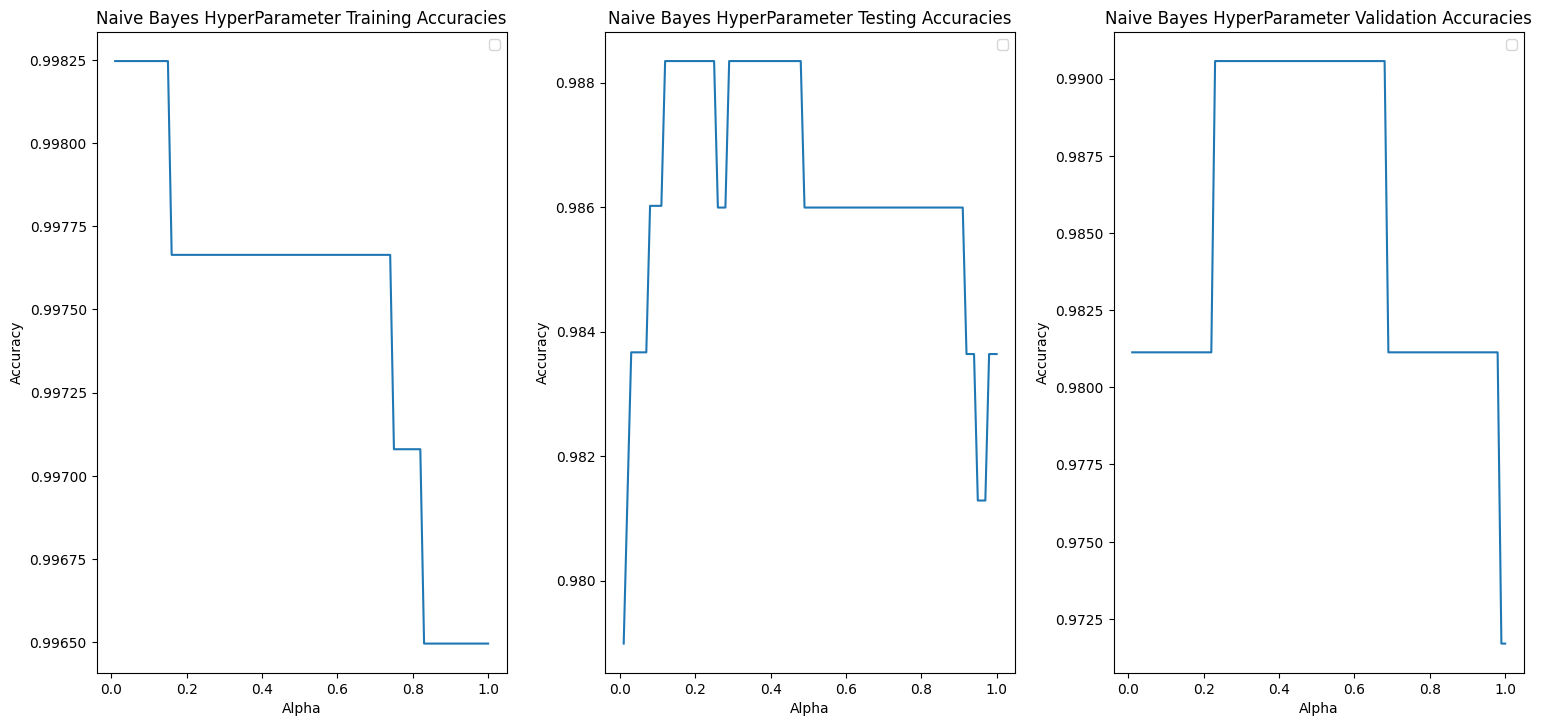

In [ ]:
########### NAIVE BAYES HYPER-PARAMETERS ###########
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

#Hyperparameters
alpha_param = np.linspace(1/100, 1, 100)

#Figure Setup
figure, axes = plt.subplots(1,3, figsize=[15, 7])
figure.tight_layout(w_pad=4,h_pad=4)

#Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
train_accuracy_scores = []
test_accuracy_scores = []
val_accuracy_scores = []
for a in alpha_param:
  model = MultinomialNB(alpha=a)
  #Train and Test
  cv_results = cross_validate(model, train_data, train_classes, cv=kfold, scoring='accuracy',return_train_score=True)
  train_accuracy_scores.append(np.mean(cv_results["train_score"]))
  test_accuracy_scores.append(np.mean(cv_results["test_score"]))

  #Validation
  model = MultinomialNB(alpha=a)
  model.fit(train_data, train_classes)
  val_accuracy_scores.append(model.score(test_data, test_classes))

# Plot List
axes[0].plot(alpha_param, train_accuracy_scores)
axes[1].plot(alpha_param, test_accuracy_scores)
axes[2].plot(alpha_param, val_accuracy_scores)

# Annotation is too tight, the values are too close together

#Axes Labels
for j in range(3):
  axes[j].legend()
  axes[j].set_xlabel("Alpha")
  axes[j].set_ylabel("Accuracy")


#Titles
axes[0].set_title(f"Naive Bayes HyperParameter Training Accuracies")
axes[1].set_title(f"Naive Bayes HyperParameter Testing Accuracies")
axes[2].set_title(f"Naive Bayes HyperParameter Validation Accuracies")

plt.show()


##Naive Bayes Hyper-parameter Setting justifications
The hyper-parameter for the Naive Bayes model is alpha. If alpha is too small the model will have high variance and overfit, in contrast if the alpha value is too high the model will underfit.

Final hyper-parameters:
- Alpha = 0.43

####Impact of Alpha
As expected the training accuracy is high, always having more than 99% accuracy. The accuracy value tends to retain it's value for multiple values of alpha before changing. The testing set and validation set both share a peak from 0.3-0.48, we can take the average value between these two sets as the optimal alpha value.

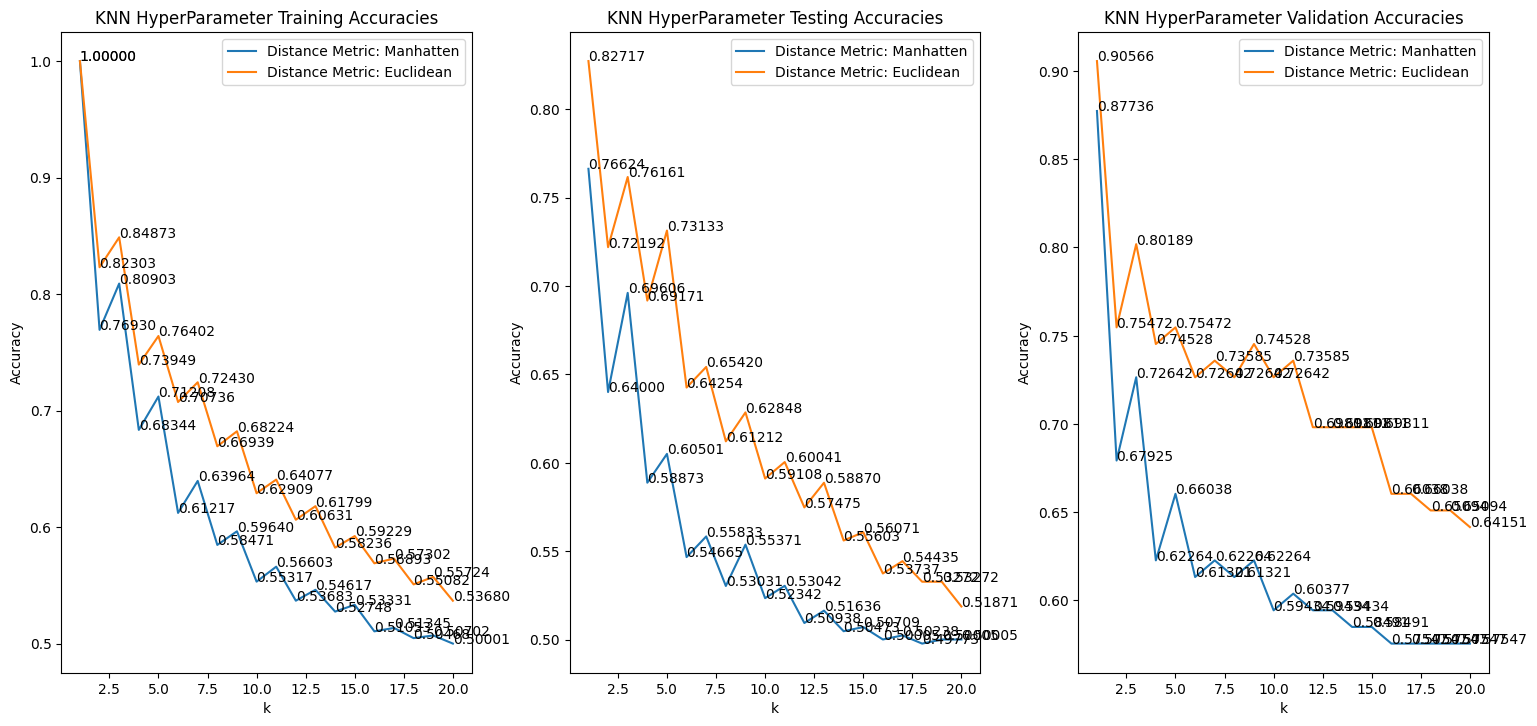

In [ ]:
########### KNN HYPER-PARAMETERS ###########
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

#Hyperparameters
n_neighbors = np.arange(1, 21)
distance_metric = ["Manhatten","Euclidean"]

#Figure Setup
figure, axes = plt.subplots(1,3, figsize=[15, 7])
figure.tight_layout(w_pad=4,h_pad=4)

#Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, distance in enumerate(distance_metric): #Distance
  train_accuracy_scores = []
  test_accuracy_scores = []
  val_accuracy_scores = []
  for k in (n_neighbors):
    model = KNeighborsClassifier(n_neighbors=k, p=i + 1)
    #Train and Test
    cv_results = cross_validate(model, train_data, train_classes, cv=kfold, scoring='accuracy',return_train_score=True)
    train_accuracy_scores.append(np.mean(cv_results["train_score"]))
    test_accuracy_scores.append(np.mean(cv_results["test_score"]))

    #Validation
    model = KNeighborsClassifier(n_neighbors=k, p=i + 1)
    model.fit(train_data, train_classes)
    val_accuracy_scores.append(model.score(test_data, test_classes))

  # Plot List
  axes[0].plot(n_neighbors, train_accuracy_scores, label=f"Distance Metric: {distance}")
  axes[1].plot(n_neighbors, test_accuracy_scores, label=f"Distance Metric: {distance}")
  axes[2].plot(n_neighbors, val_accuracy_scores, label=f"Distance Metric: {distance}")
  # Annotate Accuracy onto points (A bit messy)
  for x,y1,y2,y3 in zip(n_neighbors, train_accuracy_scores, test_accuracy_scores, val_accuracy_scores):
      axes[0].annotate(f"{y1:.5f}", (x,y1))
      axes[1].annotate(f"{y2:.5f}", (x,y2))
      axes[2].annotate(f"{y3:.5f}", (x,y3))

  #Axes Labels
  for j in range(3):
    axes[j].legend()
    axes[j].set_xlabel("k")
    axes[j].set_ylabel("Accuracy")

  #Titles
  axes[0].set_title(f"KNN HyperParameter Training Accuracies")
  axes[1].set_title(f"KNN HyperParameter Testing Accuracies")
  axes[2].set_title(f"KNN HyperParameter Validation Accuracies")

plt.show()


##K-Nearest Neighbours Hyper-parameter Setting justifications
For the K-Nearest Neighbours model, the hyper-parameters to test are the nearest neighbours K, and the distance metric. The distance metrics being compared are Euclidean and Manhatten distance.

Final hyper-parameters:
- Distance Metric = Euclidean
- K = 5

####Impact of distance metrics
Euclidean distance performed better than the Manhatten distance for every value of K

####Impact of K
Tiny values of K clearly overfit(K=1 has 100% accuracy) which tapers off quickly and begins to underfit as K increases. We find the middle ground with high accuracy in the validation and test sets at k=5.  Interestingly, when 'k' was even accuracy deceased. This is likely a result of the ties that can occur when there is an even number of neighbours.


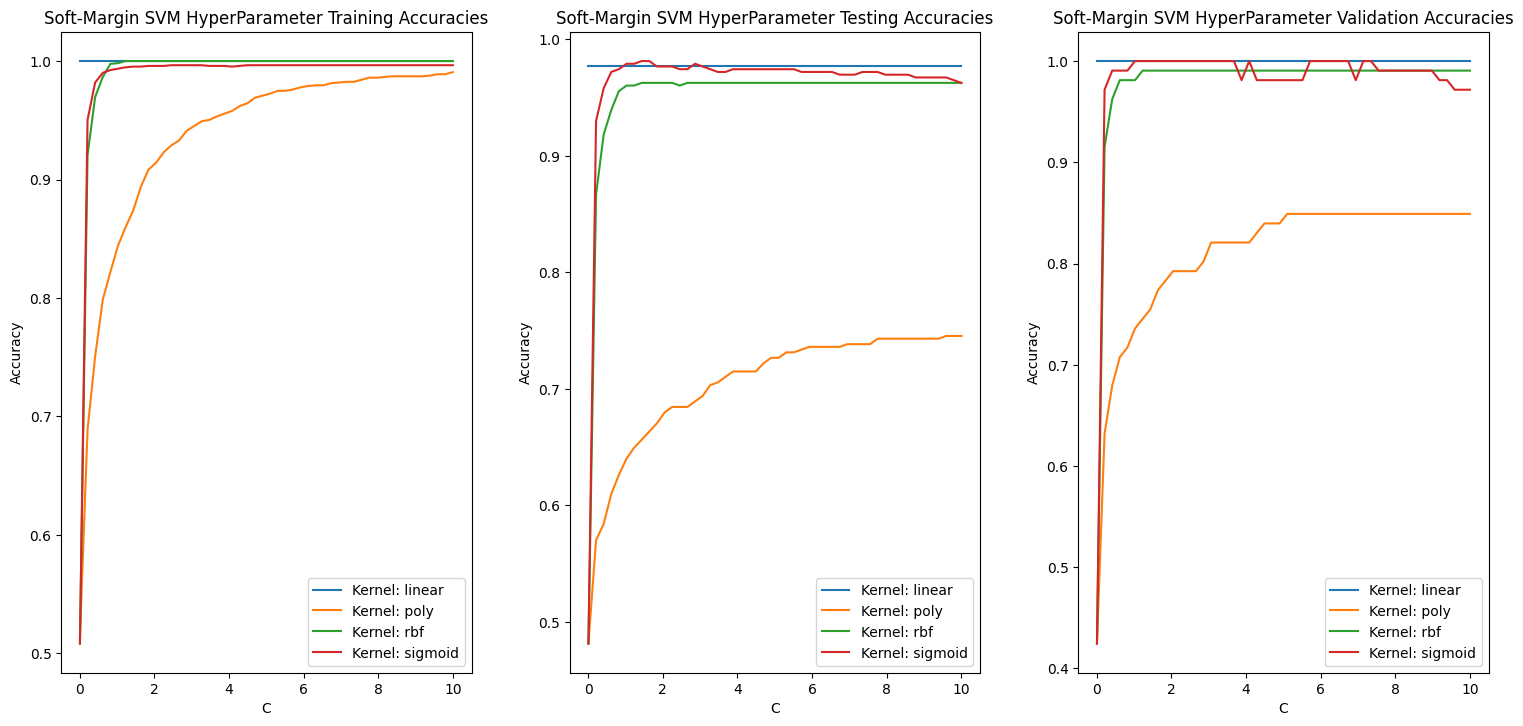

In [ ]:
########### SOFT-MARGIN-SVM HYPER-PARAMETERS ###########

#Hyperparameters
#c_param = np.linspace(1/1000, 1, 100)
#Lowered for testing
c_param = np.linspace(1/100, 10, 50)
kernels = ["linear", "poly", "rbf", "sigmoid"]

#Figure Setup
figure, axes = plt.subplots(1,3, figsize=[15, 7])
figure.tight_layout(w_pad=4,h_pad=4)

#Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, kernel_type in enumerate(kernels): #Kernel
  train_accuracy_scores = []
  test_accuracy_scores = []
  val_accuracy_scores = []
  for c_val in (c_param):
    model = SVC(kernel=kernel_type, C=c_val)
    #Train and Test
    cv_results = cross_validate(model, train_data, train_classes, cv=kfold, scoring='accuracy',return_train_score=True)
    train_accuracy_scores.append(np.mean(cv_results["train_score"]))
    test_accuracy_scores.append(np.mean(cv_results["test_score"]))

    #Validation
    model = SVC(kernel=kernel_type, C=c_val)
    model.fit(train_data, train_classes)
    val_accuracy_scores.append(model.score(test_data, test_classes))

  # Plot List
  axes[0].plot(c_param, train_accuracy_scores, label=f"Kernel: {kernel_type}")
  axes[1].plot(c_param, test_accuracy_scores, label=f"Kernel: {kernel_type}")
  axes[2].plot(c_param, val_accuracy_scores, label=f"Kernel: {kernel_type}")

  #Axes Labels
  for j in range(3):
    axes[j].legend()
    axes[j].set_xlabel("C")
    axes[j].set_ylabel("Accuracy")

  #Titles
  axes[0].set_title(f"Soft-Margin SVM HyperParameter Training Accuracies")
  axes[1].set_title(f"Soft-Margin SVM HyperParameter Testing Accuracies")
  axes[2].set_title(f"Soft-Margin SVM HyperParameter Validation Accuracies")

plt.show()


#WIP
##SVM
Hyper-parameters chosen:

Kernels:
- Linear
- Poly
- RBF
- Sigmoid

C value

Final hyper-parameters:
- Kernel = Sigmoid
- C = 1.6

####Impact of different Kernels
 - Linear: Highest consistant accuracy for all values of C
 - Poly: Lowest accuracy of the kernels,
 - rfd: High Accuracy once C was greater than 1. Grew exponentially between C=0.01 and 1
 - Sigmoid: Had the highest accuracy at C=1.6. Was the only kernel to have a decrease in accuracy.

####Impact of C
For low values of C, the accuracy of the kernels also increased. This increase tapered off for higher values of C.

In [ ]:
########### NEURAL NETWORK HYPER-PARAMETERS ###########
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier

#Hyperparameters
activations = ["identity","logistic","tanh","relu"]
solvers = ["lbfgs","sgd","adam"]
hidden_layer_counts = [5,10,20,30,40,50]
epochs = 100

#Figure Setup
figure, axes = plt.subplots(len(solvers),3, figsize=(20, 20))
figure.tight_layout(w_pad=4,h_pad=4)

#Cross Validation
print("NOTICE: THIS WILL TAKE A WHILE (Estimated 10 minutes or more)")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, solver in enumerate(solvers):
  for activation in activations:
    train_accuracy_scores = []
    test_accuracy_scores = []
    val_accuracy_scores = []
    for hidden_layer_count in hidden_layer_counts:
        # print(f"Running Batch: {i},{activation},{hidden_layer_count}")

        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore", category=ConvergenceWarning, module="sklearn"
            )
            model = MLPClassifier(random_state=0,hidden_layer_sizes=(hidden_layer_count,),learning_rate_init=0.01, max_iter=epochs,activation=activation, solver=solver, early_stopping=True)
        #Train and Test
        cv_results = cross_validate(model, train_data, train_classes, cv=kfold, scoring='accuracy',return_train_score=True)
        train_accuracy_scores.append(np.mean(cv_results["train_score"]))
        test_accuracy_scores.append(np.mean(cv_results["test_score"]))

        #Validation
        model = MLPClassifier(random_state=0,hidden_layer_sizes=(hidden_layer_count,),learning_rate_init=0.01, max_iter=epochs,activation=activation, solver=solver, early_stopping=True)
        model.fit(train_data, train_classes)
        val_accuracy_scores.append(model.score(test_data, test_classes))

    # Plot List
    axes[i][0].plot(hidden_layer_counts, train_accuracy_scores, label=f"Activation: {activation}")
    axes[i][1].plot(hidden_layer_counts, test_accuracy_scores, label=f"Activation: {activation}")
    axes[i][2].plot(hidden_layer_counts, val_accuracy_scores, label=f"Activation: {activation}")
    # Annotate Accuracy onto points (A bit messy)
    for x,y1,y2,y3 in zip(hidden_layer_counts, train_accuracy_scores, test_accuracy_scores, val_accuracy_scores):
        axes[i][0].annotate(f"{y1:.5f}", (x,y1))
        axes[i][1].annotate(f"{y2:.5f}", (x,y2))
        axes[i][2].annotate(f"{y3:.5f}", (x,y3))

    #Axes Labels
    for j in range(3):
        axes[i][j].legend()
        axes[i][j].set_xlabel("Hidden Layer Count")
        axes[i][j].set_ylabel("Accuracy")
    #Titles
    axes[i][0].set_title(f"NN HyperParameter Training Accuracies (Solver: {solver})")
    axes[i][1].set_title(f"NN HyperParameter Testing Accuracies (Solver: {solver})")
    axes[i][2].set_title(f"NN HyperParameter Validation Accuracies (Solver: {solver})")

plt.show()



## NN Hyper-parameter Setting justifications
The hyper-parameters which were chosen to test: solver, activation, the Hidden layer count, and early_stopping.
The final hyper-parameters settings chosen were: solver = lbfgs, activation = logistic, hidden_layer_sizes = (40,).
- The solver was chosen as lbfgs as it generally performed the best in terms of testing+validation accuracy, having 7 hyper-paramater settings that had accuracies over 0.975 compared to 0 and 4 respectively
- The activation was chosen as logistic as paired with lbfgs, it outperformed every other solver+activation combination at almost every hidden layer size in both testing and validation accuracy
- The hidden_layer_sizes was chosen as (40,) as it best performing hyperparameter for lbfgs+logistic combo in validation accuracy

## Over/Under Fitting observations
For the lbfgs solver
- There is not much of a observation to make, the training/testing accuracy for all models >= 0.99
- Despite the logistic activation having a decrease in its testing accuracy inversely to its training accuracy, the accuracy is within 1% difference which could be margin of error.

For the sgd solver,
- The model seems to overfit at around 10 hidden units as for all activation functions, the training/testing accuracy peaks at 10 hidden units, before the testing accuracy dips despite training accuracy generally increasing.

For the adam solver,
- Every activation function model seems to overfit the data, as the training accuracy is seemingly inversely proportional to the testing accuracy, often accuracy spikes in training accuracy is counteracted by accuracy spikes in the opposite direction in the validation accuracy.



#### Part (c)

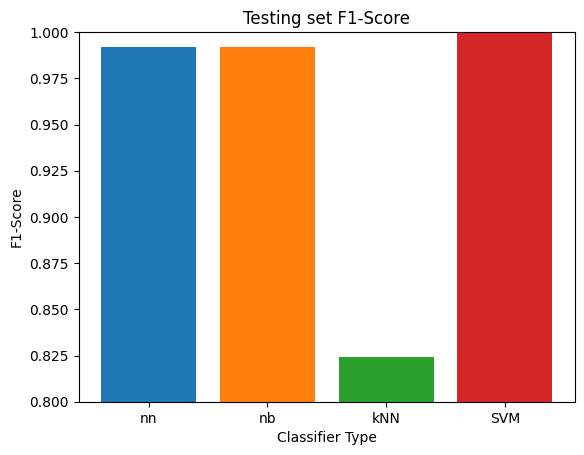

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

ideal_models = {}
ideal_models["nn"] = MLPClassifier(random_state=0,hidden_layer_sizes=(40,),learning_rate_init=0.01, max_iter=100,activation="logistic", solver="lbfgs", early_stopping=True)
ideal_models["nb"] = MultinomialNB(alpha = 0.43)
ideal_models["kNN"] = KNeighborsClassifier(n_neighbors=5, p=2)
ideal_models["SVM"] = SVC(kernel="sigmoid", C=1.6)


for name, model in ideal_models.items():
    plt.bar(name, f1_score(dataset_classes, model.fit(train_data, train_classes).predict(dataset_data), pos_label=classes[0]))

    plt.xlabel("Classifier Type")
    plt.ylim(0.8, 1)
    plt.ylabel("F1-Score")
    plt.title(f"{dataset.title()}ing set F1-Score")




# Conclusion

Soft-Margin SVM classifier was the most accurate at classifiying the articles in our test data set. kNN was the least accurate.

Naive-Bayes and Neural Networks had the same performance.